In [ ]:
import cvxpy as cp
import numpy as np

from abacus.simulator.forecaster import Forecaster
from abacus.instruments import Equity

: 

In [8]:
# Create stocks
start = "2005-12-28"
end = "2022-07-11"
interval = "wk"
stock1 = Equity(
    ric="XOM", currency="USD", start_date=start, end_date=end, interval=interval
)
stock2 = Equity(
    ric="CVX", currency="USD", start_date=start, end_date=end, interval=interval
)
stock3 = Equity(
    ric="^GSPC", currency="USD", start_date=start, end_date=end, interval=interval
)
stock4 = Equity(
    ric="WFC", currency="USD", start_date=start, end_date=end, interval=interval
)
stock5 = Equity(
    ric="MSFT", currency="USD", start_date=start, end_date=end, interval=interval
)

In [9]:
instruments = [stock1, stock2, stock3, stock4, stock5]
forc = Forecaster(instruments=instruments, number_of_steps=5)
forecasted_returns = forc.forecast_returns()

 [0.07966371 0.8354153  0.09930469] True
 [0.06109367 0.79387684 0.18175293] False
 [0.02161618 0.68328501 0.43294249] False
 [0.04267159 0.84278178 0.19959358] True
 [0.0223187  0.85344109 0.09842467] True


In [10]:
for row in forecasted_returns:
    print(row*100)

[-0.30949587 -0.15082372 -0.08620045 -0.20058877 -0.06534762]
[-0.54944713 -0.17041895 -0.06947756 -0.26894178 -0.09155867]
[-0.0519995  -0.0594126  -0.01163617 -0.00751716 -0.14104783]
[-0.19896409  0.07893548 -0.37976471 -0.29079285 -0.17944301]
[ 0.00806246 -0.24160369  0.136986   -0.11276475 -0.09367429]


In [11]:
cash_returns = np.zeros(5)
cash_returns

array([0., 0., 0., 0., 0.])

In [12]:
forecasted_returns = np.vstack([cash_returns, forecasted_returns])

In [13]:
for row in forecasted_returns:
    print(np.round(row*100, 2))

[0. 0. 0. 0. 0.]
[-0.31 -0.15 -0.09 -0.2  -0.07]
[-0.55 -0.17 -0.07 -0.27 -0.09]
[-0.05 -0.06 -0.01 -0.01 -0.14]
[-0.2   0.08 -0.38 -0.29 -0.18]
[ 0.01 -0.24  0.14 -0.11 -0.09]


In [14]:
number_of_assets = 6
number_of_steps = 5

In [15]:
Z = cp.Variable((number_of_assets, number_of_steps))
W = cp.Variable((number_of_assets, number_of_steps-1))
R = forecasted_returns
ones = np.ones(number_of_assets)
init_portfolio = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])

cost = 0
constr = []

# Building the objective function.
for t in range(number_of_steps):
    if t == 0:
        cost += R[:,t].T @ Z[:,t]
    else:
        cost += R[:,t].T @ (W[:,t-1] + Z[:,t])

# Bulding cost & constraints.
for t in range(number_of_steps):    
    if t == 0:
        constr += [ones.T @ Z[:,t] == 0,
                  Z[:,t] <= 1,
                  W[:,t] == init_portfolio + Z[:,t],
                  W[:,t] >= 0,
                  W[:,t] <= 1]
    else:
        constr += [ones.T @ Z[:,t] == 0,
                  Z[:,t] <= 1,
                  ]
        if t < number_of_steps-1:
            constr += [W[:,t] == W[:,t-1] + Z[:,t],
                       W[:,t] >= 0,
                       W[:,t] <= 1]

In [16]:
problem = cp.Problem(cp.Maximize(cost), constr)

In [17]:
problem.solve(verbose=True)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 21 11:51:52 PM: Your problem has 54 variables, 22 constraints, and 0 parameters.
(CVXPY) Aug 21 11:51:52 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 21 11:51:52 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 21 11:51:52 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 21 11:51:52 PM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 21 11:51:52 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Con

0.00913211282768442

In [18]:
print(W.value)

[[2.09870360e-08 3.61242771e-09 3.05020082e-09 9.99999996e-01]
 [3.34919430e-10 6.41977730e-10 7.21613191e-10 5.77873789e-10]
 [1.98876968e-10 5.78576708e-10 8.27239691e-10 3.81809347e-10]
 [1.35344474e-09 1.51485852e-09 1.50713773e-09 1.78147432e-09]
 [5.99202924e-10 9.99999993e-01 2.46663686e-10 2.85568637e-10]
 [9.99999977e-01 4.57901944e-10 9.99999994e-01 8.69215876e-10]]


In [19]:
print(Z.value)

[[-1.66666646e-01 -1.73746112e-08 -5.62229211e-10  9.99999993e-01
   9.99999999e-01]
 [-1.66666666e-01  3.07055389e-10  7.96331104e-11 -1.43740964e-10
   9.99999999e-01]
 [-1.66666666e-01  3.79696787e-10  2.48660475e-10 -4.45431868e-10
   9.99999998e-01]
 [-1.66666665e-01  1.61410962e-10 -7.72320378e-12  2.74334922e-10
   9.99999996e-01]
 [-1.66666666e-01  9.99999993e-01 -9.99999993e-01  3.89034387e-11
  -4.99999999e+00]
 [ 8.33333310e-01 -9.99999976e-01  9.99999993e-01 -9.99999993e-01
   9.99999998e-01]]


In [20]:
for i in range(number_of_steps-1):
    print(np.sum(W.value[:,i]))

1.0000000000000215
1.0000000000000422
1.0000000000000582
1.000000000000069


In [21]:
def power_utility(x: float, gamma: float) -> float:
    """Constant RRA utility function. Optimal for investments (source Jorgen).

    Args:
        x (float): variable value
        gamma (float): risk aversion parameter

    Raises:
        ValueError: if gamma is greater than 1.

    Returns:
        float: utility of x.
    """

    if gamma > 1:
        raise ValueError("Value of gamma is larger than 1.")
    if gamma != 0:
        return x ** gamma / gamma
    else:
        return np.log(x)

Without any constraints the portfolio simply invests eveything into the stock with the largest return.

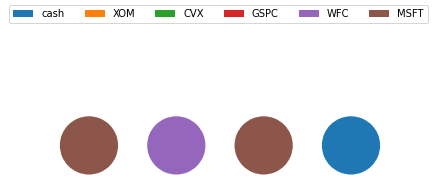

In [22]:
from matplotlib import pyplot as plt 
labels = 'cash', 'XOM', 'CVX', 'GSPC', 'WFC', 'MSFT'
explode = (0, 0.1, 0, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')
period_one = W.value[:,0]
period_two = W.value[:,1]
period_thr = W.value[:,2]
period_fou = W.value[:,3]

fig, ax = plt.subplots(1, 4)
ax[0].pie(period_one)
ax[1].pie(period_two)
ax[2].pie(period_thr)
ax[3].pie(period_fou)

fig.legend(labels, ncol=6)
plt.show()


Looking at the forecasts below we see why.

In [23]:
forecasted_returns

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-3.09495866e-03, -1.50823718e-03, -8.62004482e-04,
        -2.00588773e-03, -6.53476205e-04],
       [-5.49447126e-03, -1.70418948e-03, -6.94775621e-04,
        -2.68941777e-03, -9.15586747e-04],
       [-5.19995009e-04, -5.94125966e-04, -1.16361724e-04,
        -7.51716290e-05, -1.41047825e-03],
       [-1.98964087e-03,  7.89354800e-04, -3.79764713e-03,
        -2.90792846e-03, -1.79443014e-03],
       [ 8.06245924e-05, -2.41603686e-03,  1.36986003e-03,
        -1.12764754e-03, -9.36742919e-04]])

The objective function is maximized by investing the whole portfolio into 

Incorporating risk aversion

In [30]:
Z = cp.Variable((number_of_assets, number_of_steps))
W = cp.Variable((number_of_assets, number_of_steps-1))
R = forecasted_returns
ones = np.ones(number_of_assets)
init_portfolio = np.array([1, 0, 0, 0, 0, 0])

cost = 0
constr = []

# Building the objective function.
for t in range(number_of_steps):
    if t == 0:
        cost += R[:,t].T @ Z[:,t]
    else:
        cost += R[:,t].T @ (W[:,t-1] + Z[:,t])
cost = cp.log(cost)

# Bulding cost & constraints.
for t in range(number_of_steps):    
    if t == 0:
        constr += [ones.T @ Z[:,t] == 0,
                  Z[:,t] <= 1,
                  W[:,t] == init_portfolio + Z[:,t],
                  W[:,t] >= 0,
                  W[:,t] <= 1]
    else:
        constr += [ones.T @ Z[:,t] == 0,
                  Z[:,t] <= 1,
                  ]
        if t < number_of_steps-1:
            constr += [W[:,t] == W[:,t-1] + Z[:,t],
                       W[:,t] >= 0,
                       W[:,t] <= 1]

                

In [31]:
problem_risk_aversion = cp.Problem(cp.Maximize(cost), constr)

In [32]:
problem_risk_aversion.solve(verbose=True)

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Aug 22 01:40:24 AM: Your problem has 54 variables, 22 constraints, and 0 parameters.
(CVXPY) Aug 22 01:40:24 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 22 01:40:24 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 22 01:40:24 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 22 01:40:24 AM: Compiling problem (target solver=ECOS).
(CVXPY) Aug 22 01:40:24 AM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> Con

-4.920469687961453

In [33]:
print(W.value)

[[3.01875063e-06 2.14924971e-07 1.31038576e-07 9.99999769e-01]
 [2.33563070e-08 4.10220805e-08 4.53743020e-08 3.76468640e-08]
 [1.14490860e-08 3.68065560e-08 5.06565878e-08 2.44970073e-08]
 [1.52047838e-07 8.28485076e-08 8.27398575e-08 9.33127240e-08]
 [4.27596958e-08 9.99999591e-01 1.42894052e-08 1.68488102e-08]
 [9.99996748e-01 2.92886175e-08 9.99999672e-01 5.46663279e-08]]


In [34]:
import numpy as np
y = np.array([[1,2],[3,4],[2,4]])

In [35]:
y.shape[0]

3